# 03: Time Series

Much of climate science centers on time series analysis, particular in evaluations of climate change. The [xarray](https://xarray.pydata.org) module and its extensions provide many useful tools for working with the time evolution of climate variables and geospatial fields. This tutorial focuses on time series of climate variables.  

In [2]:
!pip install colormaps gdown
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import colormaps

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.9/727.9 kB 19.2 MB/s eta 0:00:00


And read in the same data file, but this time select total-column ozone and carbon monoxide:

In [3]:
!gdown --id {'140JTQtWrh3rGY6goZYPqL4sADcIdIQA5'}

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=140JTQtWrh3rGY6goZYPqL4sADcIdIQA5
From (redirected): https://drive.google.com/uc?id=140JTQtWrh3rGY6goZYPqL4sADcIdIQA5&confirm=t&uuid=70bda70d-1873-45b6-bdbb-cd7d66b68861
To: /content/cams_compositionreanalysis_2003-2024.1m.nc
100% 288M/288M [00:02<00:00, 106MB/s] 


In [3]:
tco3 = xr.open_dataset('cams_compositionreanalysis_2003-2024.1m.nc')['tco3']
tcco = xr.open_dataset('cams_compositionreanalysis_2003-2024.1m.nc')['tcco']

To extract a time series from a lat-lon-time grid, we can use xarray's selection methods.
- [Time series in xarray](https://docs.xarray.dev/en/stable/user-guide/time-series.html)
- [Indexing and selecting data in xarray](https://docs.xarray.dev/en/stable/user-guide/indexing.html)

Here I've selected the time series closest to Dakar. Note the ability to select the nearest CAMS grid cell to the target location, as well as the need to know whether the longitude coordinate spans 0-360° or -180-180°.

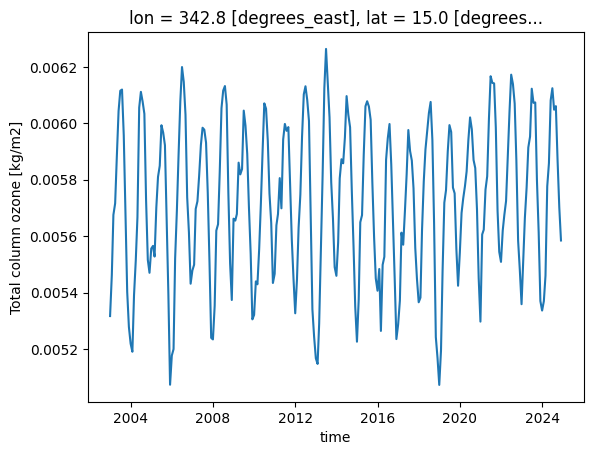

In [4]:
o3ts = tco3.sel(lon=360-17.4, lat=14.7, method='nearest')
cots = tcco.sel(lon=360-17.4, lat=14.7, method='nearest')

o3ts.plot()

In [5]:
# confirm the location of the grid cell corresponding to the
#   selected time series
o3ts
# lon 342.8
# lat 15.0

<xarray.DataArray 'tco3' (time: 264)> Size: 1kB
[264 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2024-12-01
    lon      float64 8B 342.8
    lat      float64 8B 15.0
Attributes:
    long_name:  Total column ozone
    units:      kg/m2
    code:       206
    table:      210

It is difficult to tell whether there is any change in total column ozone over this period. To better address this question, we can improve on the presentation. For example, using groupby we can compute the time series of annual means to reduce the month-to-month noise:

In [6]:
o3ts_yr = o3ts.groupby('time.year').mean('time')
cots_yr = cots.groupby('time.year').mean('time')

And plot the time series for each species to see how they compare:

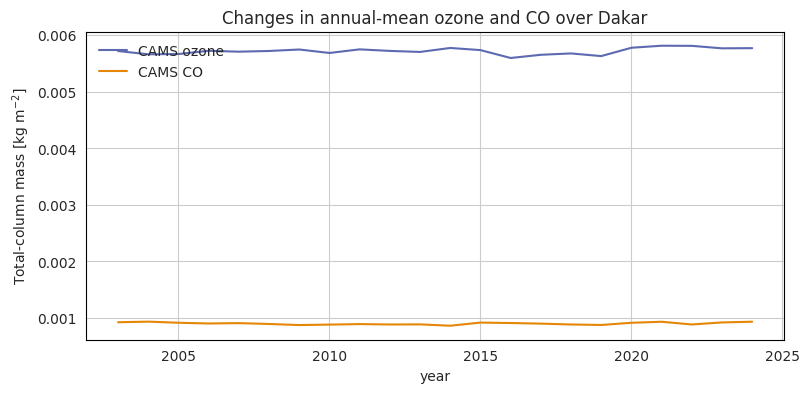

In [7]:
clrs = colormaps.vivid.colors

sns.set_style('whitegrid', {"axes.edgecolor": "k"})

fig = plt.figure(figsize=(9,4))
axs = fig.add_subplot(111)

o3ts_yr.plot(color=clrs[1], label='CAMS ozone')
cots_yr.plot(color=clrs[0], label='CAMS CO')

axs.set_ylabel('Total-column mass [kg m$^{-2}$]')
axs.set_title('Changes in annual-mean ozone and CO over Dakar')
axs.legend(frameon=False, loc='upper left')

plt.show()

The two species have very different abundances in the atmosphere. To account for this, we can add a second y axis to the right of the plot. We can also adjust the units for mass from kg to g.

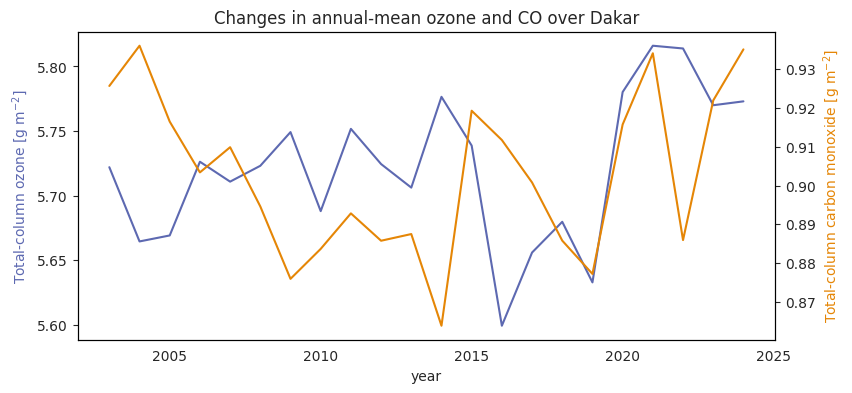

In [8]:
clrs = colormaps.vivid.colors

sns.set_style('white', {"axes.edgecolor": "k"})

fig = plt.figure(figsize=(9,4))
axs = fig.add_subplot(111)
ax2 = axs.twinx()

(1000*o3ts_yr).plot(ax=axs, color=clrs[1], lw=1.5, label='CAMS ozone')
(1000*cots_yr).plot(ax=ax2, color=clrs[0], lw=1.5, label='CAMS CO')

axs.set_ylabel('Total-column ozone [g m$^{-2}$]', color=clrs[1])
ax2.set_ylabel('Total-column carbon monoxide [g m$^{-2}$]', color=clrs[0])
axs.set_title('Changes in annual-mean ozone and CO over Dakar')
ax2.set_title('') # Used to remove the default xarray title

plt.show()

If we need more detail, we could instead compute monthly anomalies by removing the mean seasonal cycle.

Fortunately, xarray makes this easy.

- [Grouping in xarray](https://docs.xarray.dev/en/stable/user-guide/groupby.html)

In [9]:
# Anomaly from mean annual cycle
o3ts_mn = o3ts.groupby('time.month') - o3ts.groupby('time.month').mean('time')
cots_mn = cots.groupby('time.month') - cots.groupby('time.month').mean('time')

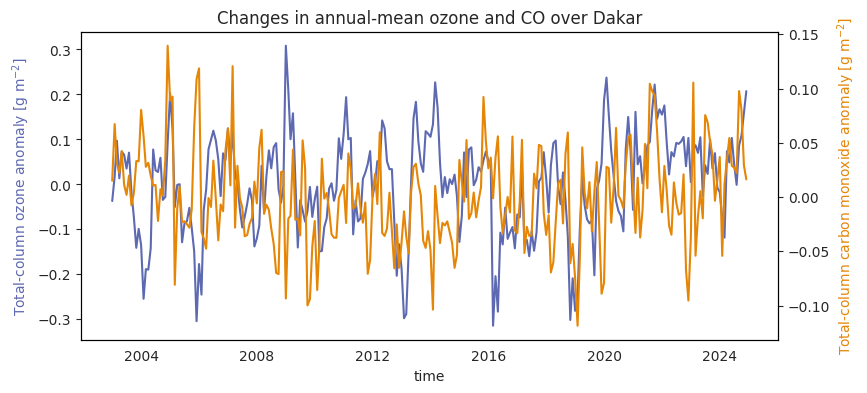

In [10]:
clrs = colormaps.vivid.colors

sns.set_style('white', {"axes.edgecolor": "k"})

fig = plt.figure(figsize=(9,4))
axs = fig.add_subplot(111)
ax2 = axs.twinx()

(1000*o3ts_mn).plot(ax=axs, color=clrs[1], lw=1.5, label='CAMS ozone')
(1000*cots_mn).plot(ax=ax2, color=clrs[0], lw=1.5, label='CAMS CO')

axs.set_ylabel('Total-column ozone anomaly [g m$^{-2}$]', color=clrs[1])
ax2.set_ylabel('Total-column carbon monoxide anomaly [g m$^{-2}$]', color=clrs[0])
axs.set_title('Changes in annual-mean ozone and CO over Dakar')
ax2.set_title('') # Used to remove the default xarray title

plt.show()

With a little manipulation, we can make even more types of statistical plots.

- [seaborn example gallery](https://seaborn.pydata.org/examples/index.html)

Here we define a new coordinate that indicates the decade of the monthly anomaly and use this to create a categorical plot.

- [reshaping and reorganizing in xarray](https://docs.xarray.dev/en/stable/user-guide/reshaping.html)

For this example, we load surface air temperature from the ERA5 reanalysis to make it more meaningful to sort by decade.

In [4]:
!gdown --id {'1sfL2pGgq2kZD-0oYc15PcNNpv-cN4ppv'}

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sfL2pGgq2kZD-0oYc15PcNNpv-cN4ppv
To: /content/ERA5_surface_common-grid_monthly_t2m_1940-2024.nc
100% 43.0M/43.0M [00:00<00:00, 182MB/s]


In [13]:
tas = xr.open_dataset('ERA5_surface_common-grid_monthly_t2m_1940-2024.nc')['t2m']

# In this case, the longitude range is from -180 to 180
tas_ts = tas.sel(lon=-17.4, lat=14.7, method='nearest')
print(tas_ts.lon.values, tas_ts.lat.values)

# Set climatology to 1961-1990
#   (note that years should be passed as strings when selecting from time)
tas_cl = tas_ts.sel(time=slice('1961','1990')).mean('time')
# Compute anomalies
tas_ts = tas_ts.groupby('time.year').mean('time') - tas_cl

-17.5 15.0


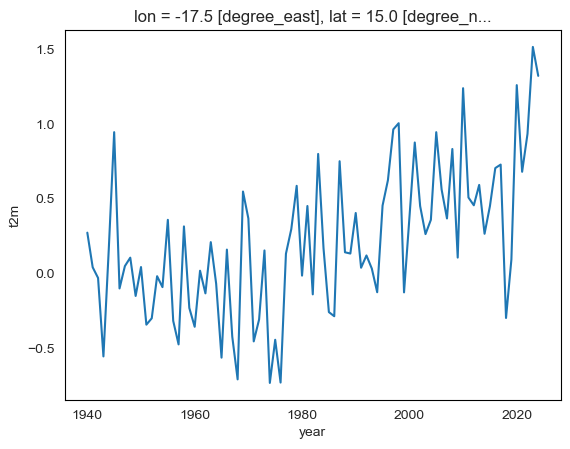

In [ ]:
tas_ts.plot()

In [14]:
# Sort by decade
year = tas_ts.year.values
dcde = 1940 + 10*((year - year[0]) / 10).astype(int)
# Note that the 'time' axis is now named 'year'
tas_dec = tas_ts.assign_coords({'decade': ('year', dcde)})
# By adding 'decade' as a new coordinate matched to 'year', we can group the years
#   by decade -- uncomment below to see the result
# print(dec_tas['decade'])

Here we use [seaborn stripplot](https://seaborn.pydata.org/generated/seaborn.stripplot.html) to show the magnitudes of annual-mean anomalies within each decade and [seaborn regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html) to show the linear trend. For the trend, we use the axis locations assigned by the categorical plot (starting from 0.5 and with each decade spaced by 1) rather than the years themselves. The regplot method automatically adds a bootstrap confidence interval around the trend line unless we turn this feature off. In this case I have set it to 99%.

Temperatures over the five years 2020-2024 have all exceeded the expected decadal mean based on the linear trend over 1940-2020.

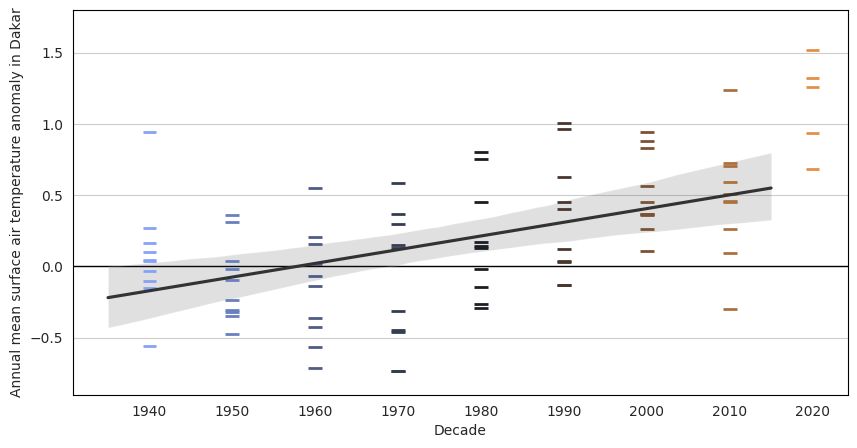

In [15]:
# Plot preliminaries
sns.set_style('whitegrid', {"axes.edgecolor": "k"})
clrs = colormaps.orangeblue_dark_r.discrete(17) # read in 17 colors from the map
fig, axs = plt.subplots(figsize=(10,5))

# Plotting
axs.axhline(0, color='k', linewidth=1, zorder=1)
sns.stripplot(ax=axs, x=tas_dec['decade'], y=tas_dec.values, hue=tas_dec['decade'], palette=clrs, legend=False,
              jitter=False, s=10, marker='_', linewidth=2)
sns.regplot(ax=axs, x=np.linspace(-0.5,7.5,81), y=tas_ts.sel(year=slice(1940,2020)).values,
            color='#333', scatter=False, ci=99, line_kws={'zorder': 10})
axs.set_ylim((-0.9, 1.8))
axs.set_ylabel('Annual mean surface air temperature anomaly in Dakar')
axs.set_xlabel('Decade')
plt.show()

The trend is highly significant, but how large is it? Python has many modules for statistical analysis, including some that extend xarray.

- [scipy stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
- [statsmodels](https://www.statsmodels.org/stable/index.html)
- [scikit-learn](https://scikit-learn.github.io/stable)

Here we use the most accessible, scipy, to calculate the trend based on decadal means, starting from 1940 and ending in 2019 (eight complete decades):

In [16]:
from scipy.stats import linregress
res = linregress(np.arange(8), tas_dec.sel(year=slice(1940,2019)).groupby('decade').mean('year'))
print(res)

LinregressResult(slope=np.float64(0.09062536330450148), intercept=np.float64(-0.16560414632161458), rvalue=np.float64(0.8343576726719011), pvalue=np.float64(0.009997221911268263), stderr=np.float64(0.024442720608691904), intercept_stderr=np.float64(0.10225123636516582))


ERA5 indicates a ~0.09±0.05°C per decade trend in surface air temperature in the grid cell containing Dakar over 1940-2019. The simple Student's *t* test used by [scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) indicates that the slope is different from zero at *p* < 0.01. Because the test applied in this case assumes sample independence only at the decadal time scale (*n*=8, a conservative assumption), we can assign a high level of confidence to the sign of the trend.